# CLIM680: Assignment 3, written by Tehreem Qureshi. 

### In this code, I use monthly sums of ERA5 precipitation data (mm) and the [Pacific Decadal Oscillation Index](https://psl.noaa.gov/data/climateindices/caveats.html). In oceanography we've discussed the role of PDO in affecting precipitation in the Pacific, so I am interested in seeing how it may have teleconnections elsewhere as well. 

### The multipanel plots for the assignment are starred * [ ] * in their Markdown title.

In [14]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

### ERA5 Monthly Sum Precipitation Data 

In [15]:
filename = '/home/tquresh/clim680/monthly_precip_sum.nc' # monthly values of total precipitation (m) from 1979-2022
monthly_precip19792022 = xr.open_dataset(filename)
monthly_precip19792022 
monthly_precip19792022['tp'] = monthly_precip19792022['tp'] * 1000  # change to mm from m
monthly_precip19792022['tp'].attrs['units'] = 'mm'

# fix lats and lons to go from -90 to 90 and -180 to 180, because era5 has different lats and lons automatically and code from class assumes below set up, making it faster
monthly_precip19792022 = monthly_precip19792022.sortby('latitude')
monthly_precip19792022 = monthly_precip19792022.assign_coords(longitude=((monthly_precip19792022['longitude']+180) % 360)-180)
monthly_precip19792022 = monthly_precip19792022.sortby(monthly_precip19792022['longitude'])

In [16]:
# check all preprocessing worked 
monthly_precip19792022

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 528, latitude: 721, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2022-12-01
  * latitude    (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude   (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    number      int64 8B ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 2GB 1.172 ... 17.19

In [17]:
# calculate precip anomalies using 1979-2022 climatology 

precip_clim = monthly_precip19792022.groupby('valid_time.month').mean()
precip_anoms = monthly_precip19792022.groupby('valid_time.month') - precip_clim
precip_anoms

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 528, latitude: 721, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2022-12-01
  * latitude    (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude   (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    number      (valid_time) int64 4kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    month       (valid_time) int64 4kB 1 2 3 4 5 6 7 8 9 ... 5 6 7 8 9 10 11 12
Data variables:
    tp          (valid_time, latitude, longitude) float32 2GB -2.576 ... 2.438

### Pacific Decadal Oscillation Index Time Series

In [18]:
# read in pacific decadal oscillation indices csv (made using Google Sheets) 

pdo_indices =  pd.read_csv('PDO_indices.csv')

In [19]:
# turn pdo csv into xarray dataarray so we can use composite and stats methods. Note I used Chatgpt to do the conversion from csv to Data Array, have tested this, and tweaked it a bit.
#(No other code is AI-generated - I only use class examples as reference.)
 
# -> start ChatGPT 
pdo = (
    pdo_indices.set_index("Year")
      .stack()   
      .rename_axis(["Year", "Month"]) # instead of year and month columns, this stacks them so we can turn each row into a datetime value
      .reset_index(name="PDO Index")
)

pdo["time"] = pd.to_datetime(pdo["Year"].astype(str) + "-" + pdo["Month"] + "-01") # this makes the conversion much easier because it automatically takes the "stack" and converts to datetime 

pdo_da = xr.DataArray(
    pdo["PDO Index"].where(pdo ["PDO Index"] != -9.90), # remove NaNs (there are 6; this -9.90 how PDO defines missing values)
    coords={"valid_time": pdo["time"]},
    dims=["valid_time"],
    name="PDO Index"
)
# -> end ChatGPT 
pdo_da = pdo_da.sel(valid_time=slice('1979-01-01T00:00:00.000000000', '2022-12-01T00:00:00.000000000')) # align pdo with time values of precip 

### Defining PDO thresholds: 

### Positive when PDO >= 1
### Negative when PDO =< -1
### Neutral when PDO is (-1, 1)

#### I experimented with thresholds being (>0) and (<0) and (>.5) and (<.5), but these sample sizes were fairly skewed (only positive or negative only saw 1 neutral conditions). The above thresholds give a good range for composites.

Positive PDO:  129
Neutral:  315
Negative PDO:  78


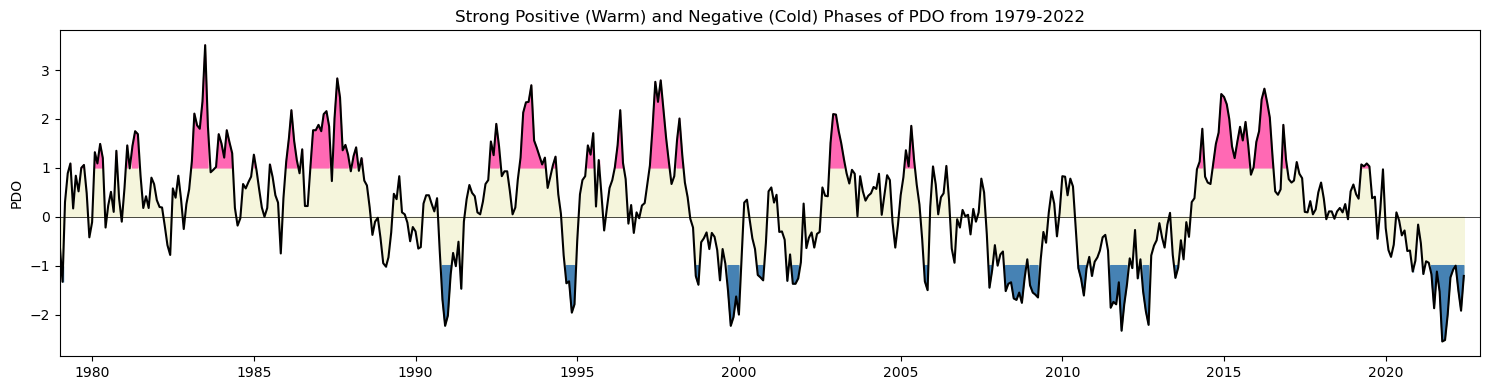

In [20]:
plt.figure(figsize=(15, 4))
positive_pdo=pdo_da.where(pdo_da>=1)
negative_pdo=pdo_da.where(pdo_da<=-1)
neutral_pdo=pdo_da.where((pdo_da<1) & (pdo_da>-1))

print('Positive PDO: ',positive_pdo.count(dim='valid_time').values)
print('Neutral: ',neutral_pdo.count(dim='valid_time').values)
print('Negative PDO: ',negative_pdo.count(dim='valid_time').values)

plt.plot(pdo_da['valid_time'],pdo_da,'k')
plt.fill_between(pdo_da['valid_time'].values,pdo_da,color='beige') # neutral!
plt.fill_between(pdo_da['valid_time'].values,positive_pdo,y2=1,color='hotpink')
plt.fill_between(pdo_da['valid_time'].values,negative_pdo,y2=-1,color='steelblue')

plt.axhline(0,color='black',linewidth=0.5)
plt.title('Strong Positive (Warm) and Negative (Cold) Phases of PDO from 1979-2022')
plt.ylabel('PDO')
plt.xlim(pdo_da['valid_time'].min(), pdo_da['valid_time'].max())
plt.tight_layout()

# counts add up to 522 - we have 6 NaNs in the PDO, so this checks out with our 528 time steps.

In [21]:
# select precip anomalies where the PDO phases align 

pospdo_precip = precip_anoms['tp'].sel(valid_time=positive_pdo.dropna(dim='valid_time')['valid_time']).mean(dim='valid_time')
negpdo_precip = precip_anoms['tp'].sel(valid_time=negative_pdo.dropna(dim='valid_time')['valid_time']).mean(dim='valid_time')
neutral_precip = precip_anoms['tp'].sel(valid_time=neutral_pdo.dropna(dim='valid_time')['valid_time']).mean(dim='valid_time')

comp_precip = [pospdo_precip,neutral_precip, negpdo_precip] #these are the different composites we will loop over

## * Multipanel Plot of Composites of PDO Phases *

Text(0.5, 0.72, 'Composite Precipitation Anomalies during PDO')

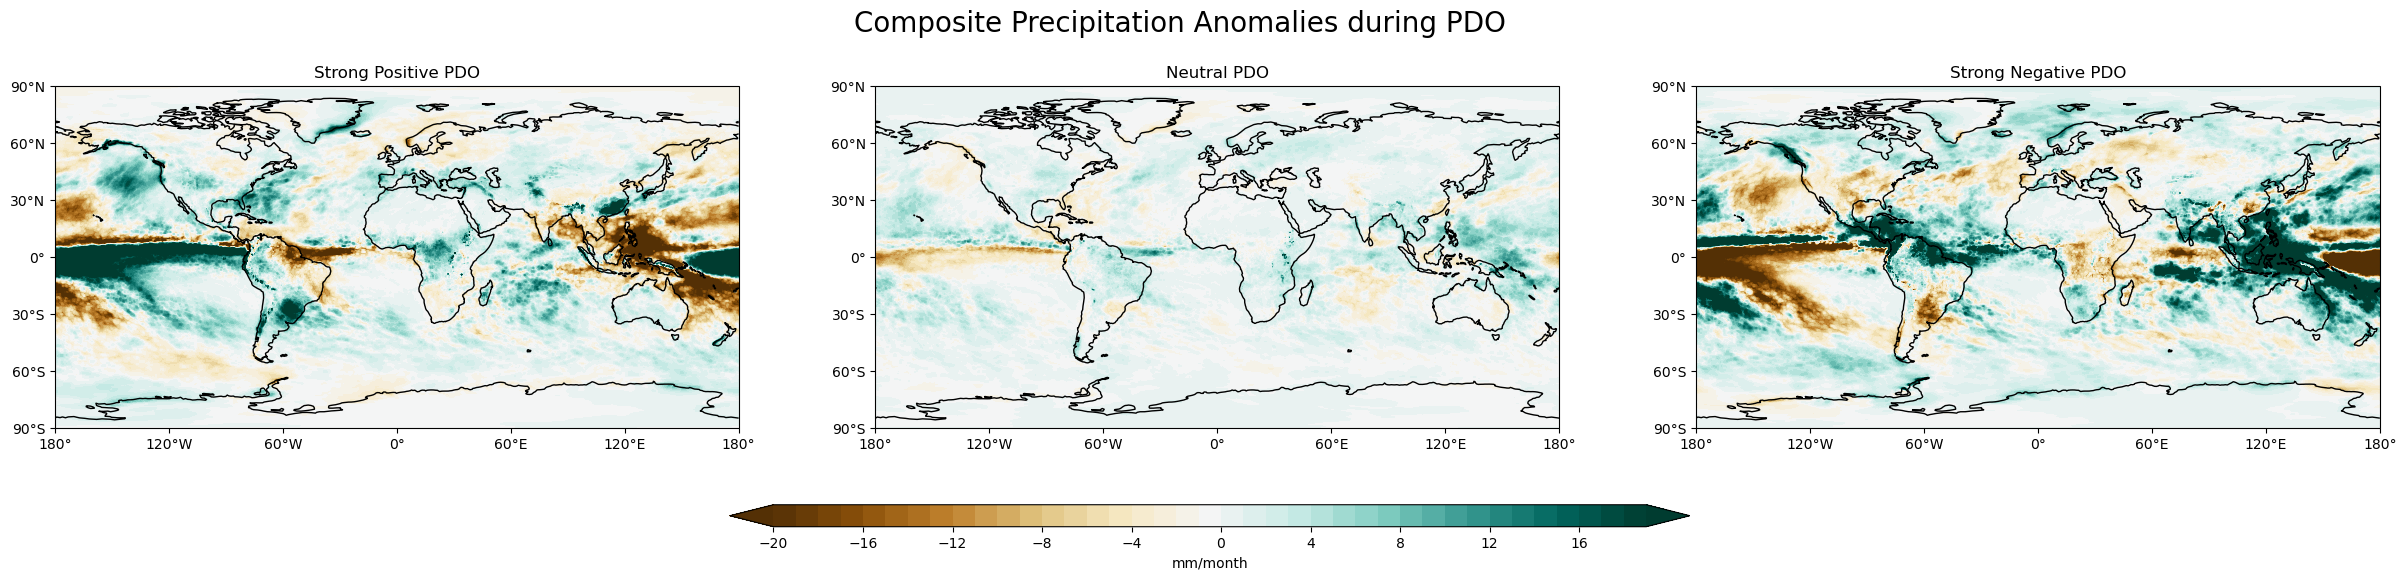

In [22]:
labels=['Strong Positive PDO','Neutral PDO', 'Strong Negative PDO']
clevs = np.arange(-20, 20, 1)

fig, axs = plt.subplots(nrows=1,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(30,11))

axs = axs.flatten()


for i,pdo in enumerate(comp_precip):

        data = comp_precip[i]

        data,lons = add_cyclic_point(data,coord=comp_precip[i]['longitude'])

        cs=axs[i].contourf(lons,comp_precip[i]['latitude'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        axs[i].set_title(labels[i])

        axs[i].coastlines()
cbar_ax = fig.add_axes([0.35, 0.25, 0.32, 0.02])
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/month')

plt.suptitle('Composite Precipitation Anomalies during PDO', fontsize=20, y=.72)

### Analyzing differences during strong positive and strong negative phases compared to neutral conditions. This helps us visualize and motivate the next part, which is if the differences are statistically significant (is there a robust shift in climate variability based on phase and not just chance?)

In [23]:
diff_precip = [pospdo_precip - neutral_precip, negpdo_precip - neutral_precip] 

Text(0.5, 0.98, 'Composite Precipitation Differences during PDO')

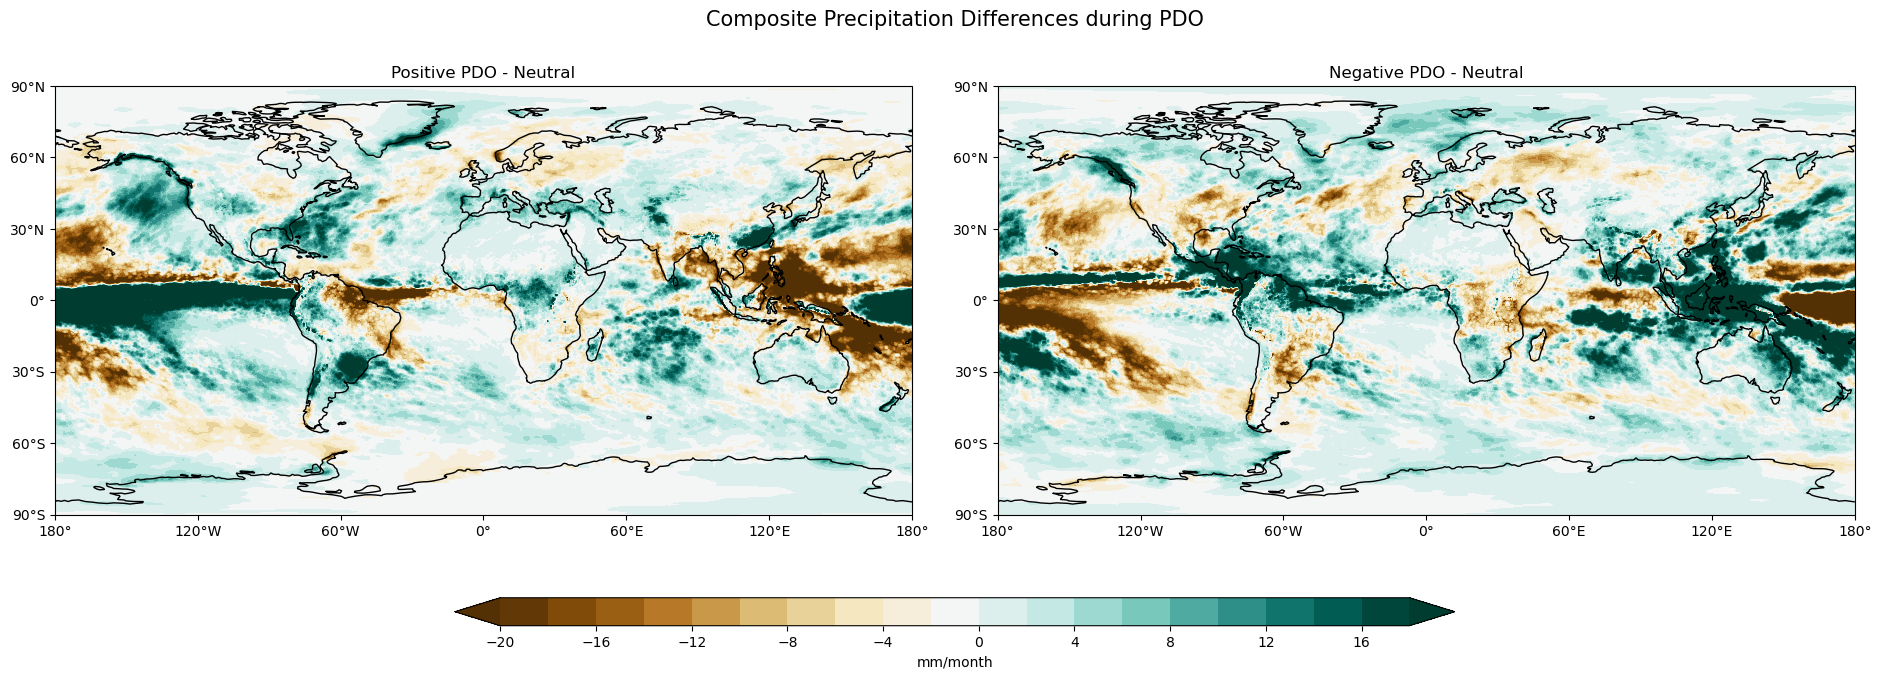

In [27]:
labels=['Positive PDO - Neutral','Negative PDO - Neutral']
clevs=np.arange(-20, 20, 2)

fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,7))

axs = axs.flatten()

for i, pdo in enumerate(diff_precip):

        data = diff_precip[i]

        data,lons = add_cyclic_point(data,coord=diff_precip[i]['longitude'])

        cs = axs[i].contourf(lons,diff_precip[i]['latitude'],data,clevs,
                          transform=ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        axs[i].set_title(labels[i])

        axs[i].coastlines()
        

fig.subplots_adjust(bottom=0.25, top=0.88, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

cbar_ax = fig.add_axes([0.25, 0.10, 0.5, 0.04])

cbar = fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm/month')

plt.suptitle('Composite Precipitation Differences during PDO', fontsize = 15)

### Calculate statistical signifiance using p of .05 (95% confidence level). We are testing the null hypothesis which is that the difference between means is zero and all differences arise due to chance. Use two-sided test based on Student's t-test.

In [28]:
p = .05
from scipy.stats import ttest_ind

pospdo_precip_vals = precip_anoms['tp'].sel(valid_time=positive_pdo.dropna(dim='valid_time')['valid_time']) # aligning times as we did before, but this time not averaging over time spatial relationship
negpdo_precip_vals = precip_anoms['tp'].sel(valid_time=negative_pdo.dropna(dim='valid_time')['valid_time'])
neutralpdo_precip_vals = precip_anoms['tp'].sel(valid_time=neutral_pdo.dropna(dim='valid_time')['valid_time'])

## calculate t-test for positive pdo and neutral, call it with subscript 1 with the mask

tstat1,pval1=ttest_ind(pospdo_precip_vals, 
                neutralpdo_precip_vals, 
                equal_var = False) # assume no equal variance

mask_diff1 = diff_precip[0].where(pval1 <= p) 
mask_diff1


## calculate t-test for neg pdo and neutral, call it with subscript 2 

tstat2,pval2=ttest_ind(negpdo_precip_vals, 
                neutralpdo_precip_vals, 
                equal_var = False)

mask_diff2 = diff_precip[1].where(pval2 <= p)
mask_diff2

mask_diff = [mask_diff1, mask_diff2] # masks to be used in loop for plot

## * Multipanel plot of Composites with Hatched Areas of Statistical Signifiance *

Text(0.5, 0.99999, 'Composite Precipitation Differences of PDO Phase - Neutral')

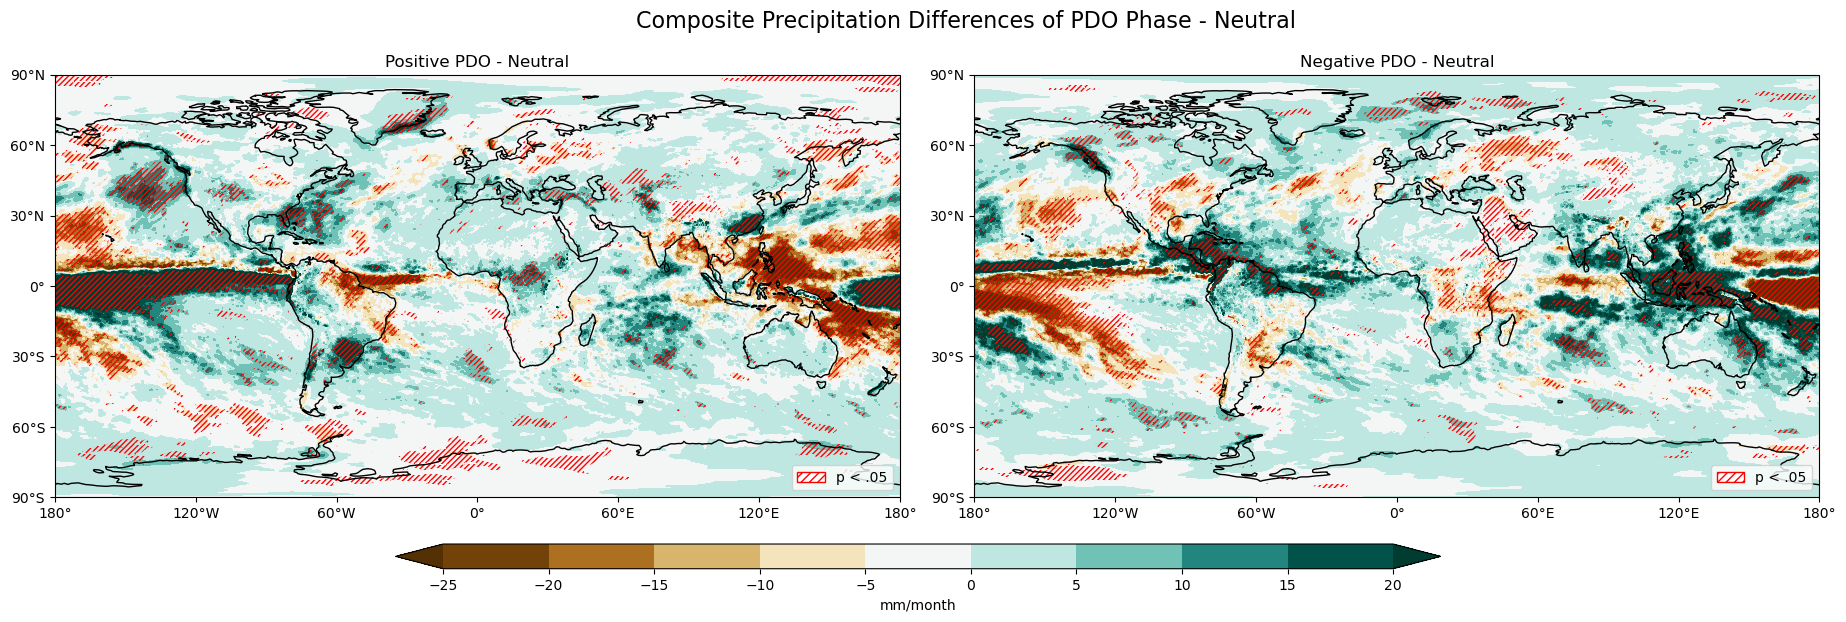

In [26]:
import matplotlib.patches as mpatches
import matplotlib as mpl

clevs=np.arange(-25, 25, 5)
mpl.rcParams['hatch.color'] = 'red' #had a hard time seeing the black hatches because of how dark some parts of map are, switched to red

fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(19,6.5))

for i, pdo in enumerate(diff_precip):

    data=diff_precip[i] 

    data,lons=add_cyclic_point(data,coord=diff_precip[i]['longitude'])
    mask_data,lons=add_cyclic_point(mask_diff[i],coord=diff_precip[i]['longitude'])
    axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)


        
    cs = axs[i].contourf(lons,diff_precip[i]['latitude'],data,clevs,
                        transform = ccrs.PlateCarree(),
                        cmap='BrBG',extend='both')

    axs[i].contourf(lons,diff_precip[i]['latitude'],mask_data,[0,1],
                  transform = ccrs.PlateCarree(),colors='None',
                 hatches=['//////',''],extend='both', alpha=0) # found star hatches easiest to see with this colorbar
     
    axs[i].set_title(labels[i])
    axs[i].coastlines()
    patch = mpatches.Patch(edgecolor='red', facecolor = 'white', hatch='////', label='p < .05') ## add legend
    axs[i].legend(handles=[patch], loc='lower right')
    
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.02, right=0.95,
                    wspace=0.085, hspace=0.5)

cbar_ax = fig.add_axes([0.2, 0.14, 0.55, 0.038])

cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm/month')

plt.suptitle('Composite Precipitation Differences of PDO Phase - Neutral', fontsize = 16, y=.99999)
